## Simulation BASED INFERENCE for JULICH dataset

Upload basic packages

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
from sklearn import linear_model

Upload TVB packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#import utils
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
from src import data,analysis,simulation, FC_analysis
from tvb.datatypes.time_series import *
import socket
from datetime import datetime
from multiprocessing import Pool
from functools import partial
import os
from scipy.io.matlab import loadmat
from tvb.simulator.lab import *
#import ipywidgets as widgets
# Pay attention that it crashes with any other interactive package
#from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
LOG = get_logger('demo')
import scipy.stats
from scipy.stats import zscore
#import sklearn
#from sklearn.decomposition import FastICA
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re

/Users/mariolavanga/Documents/GitHub/ageing_virtual_brain/env/lib/python3.7/site-packages/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


Import the SBI packages

In [4]:
import torch
import sbi 
import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi,simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

from scipy import signal
from scipy.signal import hilbert

from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

import scipy

from scipy.optimize import fsolve
from scipy.optimize import root

from numpy import linalg as LA
from sklearn.decomposition import PCA

Define your target/results folder

In [5]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on numba: v{}'.format(numba.__version__))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))
print('Running on numpba: v{}'.format(numba.__version__))

Running on numpy: v1.20.3
Running on numba: v0.53.1
Running on torch: v1.8.1
Running on sbi: v0.16.0
Running on numpba: v0.53.1


In [6]:
1000/(8*20)

6.25

In [7]:
separator  = ''
P_LIST     = ['sub-1209']
AGE_LIST   = [76.3]
mysubj_idx = 0
mysubj     = P_LIST[mysubj_idx]
magic_number = 124538.470647693 #SC COHORT MAX FOR JULICH DATASET
BOLD_TR      = 2250
print(len(P_LIST))

1


In [8]:
# Upload Julich dataset, the list of regions and the list of metadata of each patient. Please pay attention that the code uploads both 
# subjs list of the folder and the subj list of csv. Do refer to the variable subjs and the sorted output based on the available data in the folder
separator = ''
jul         = data.Julich() 
#subj_age,gender,education,subj_ID = jul.metadata()
subj_age,gender,education,subj_ID,age_sort,gender_sort,gender_sort,subjs = jul.metadata()
subjs        = jul.list_subjects()
SUBJ_TARG    = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]
print(subj_ID[SUBJ_TARG])
print(subj_age[SUBJ_TARG])
_,weights     = jul.load_subject_sc_100(mysubj)
NHALF         = int(weights.shape[0]/2)

sub-1209
76.3


Upload the data. You can use the class data of the Virtual Ageing Brain or uncomment the local folder upload. For the latter, **MODIFY THE run_sim() accordingly**

In [9]:
Res_dir     = jul.data_root
path_root   = os.path.dirname(os.path.dirname(os.getcwd()))
cwd = os.getcwd()

In [10]:

N_VECT     = np.array([0.035])
N_TAU      = N_VECT
N_TAU      = list(N_TAU.round(7))
A_TAU      = [0.0]
B_TAU      = [0.0]

P_LIST     = ['sub-1209']

N_LIST     = N_TAU
SIM_BATCH  = 4

In [11]:
G_LIST     = [2.9618384,
 3.1395926,
 2.0818776,
 1.8156225,
 2.5754605,
 1.9997423,
 2.6424257,
 2.9016507,
 1.9058259,
 2.6662117,
 1.8383265,
 1.6659463,
 3.2275907,
 2.4093109,
 2.4677862,
 3.0471092,
 1.8412488,
 2.6625926,
 1.7984856,
 2.5338452,
 2.223846,
 2.5988413,
 2.026169,
 2.8679142,
 2.6775879,
 2.0526757,
 2.3756662,
 2.8314022,
 2.2635491,
 3.1498051,
 3.043812,
 2.6983116,
 2.9308037,
 1.5095215,
 2.8702681,
 1.5767795,
 3.0732078,
 1.5193512,
 2.1059936,
 2.9827711,
 2.9551355,
 3.2354444,
 1.8869302,
 1.9431469,
 3.030252,
 2.9389118,
 2.4328691,
 2.663704,
 2.7014689,
 2.980873,
 2.3844488,
 2.3871132,
 1.9442639,
 2.3076403,
 3.1107716,
 3.0321167,
 1.8783361,
 2.2896057,
 1.8159113,
 2.9903499,
 1.9918867,
 2.8188515,
 2.9942892,
 1.901349,
 2.1777021,
 1.5855208,
 2.702182,
 3.0222772,
 3.1891662,
 2.9649609,
 3.0210857,
 2.3325476,
 2.4577605,
 1.6608991,
 1.5482321,
 3.2232829,
 1.7192373,
 3.202423,
 2.4163848,
 2.9124406,
 2.5610785,
 2.322196,
 2.0923198,
 1.6623366,
 3.1235607,
 1.6994094,
 1.6399073,
 1.9374049,
 2.6136883,
 2.5903159,
 1.8143487,
 3.0684242,
 1.7514855,
 2.0887242,
 2.1028461,
 1.5861982,
 2.9874534,
 3.0244591,
 1.5233277,
 2.8681034,
 2.4457277,
 2.1269768,
 2.682049,
 1.996678,
 2.6556215,
 2.460228,
 2.7985629,
 3.0379738,
 2.8690817,
 2.1811555,
 2.8180727,
 2.9769359,
 2.2558573,
 2.7666837,
 3.0484779,
 1.7822445,
 1.9761885,
 2.8445811,
 1.6732405,
 1.5245103,
 3.0963933,
 2.9403391,
 1.5381701,
 1.5532021,
 1.635103,
 1.6977178,
 2.5210103,
 2.1184497,
 1.5122104,
 3.1632982,
 1.6814289,
 2.1359691,
 3.0864298,
 3.1727742,
 2.7769667,
 2.7623559,
 2.0340928,
 2.5262881,
 2.7182833,
 3.1332689,
 3.194125,
 1.6776395,
 2.9207716,
 1.7017474,
 2.5429712,
 2.6914338,
 1.9590277,
 2.3495309,
 2.4838189,
 3.1401557,
 1.7955126,
 1.7441492,
 2.9046548,
 1.9554756,
 2.1507057,
 2.8720356,
 2.1510988,
 2.4342982,
 1.943963,
 2.0754538,
 2.7869607,
 1.6434409,
 2.3951114,
 1.9246327,
 2.6827299,
 3.2353151,
 1.6061979,
 2.732359,
 3.2326081,
 3.1533015,
 1.611543,
 1.7591655,
 2.4069154,
 1.6500741,
 2.5725774,
 2.4244687,
 2.2956074,
 2.5102959,
 2.2625964,
 1.6531588,
 1.945475,
 2.5567723,
 3.1057429,
 2.027185,
 3.1722273,
 2.2602885,
 2.073727,
 1.6802938,
 3.2391633,
 2.1501061,
 2.5316403,
 2.8549936,
 1.8869925,
 3.0971822,
 2.1253564,
 3.219394,
 3.1666202,
 1.5289916,
 2.6616496,
 2.8586471,
 2.5719196,
 2.3994027,
 3.1998145,
 1.7885022,
 1.8476088,
 1.7098042,
 3.0064966,
 1.6650509,
 1.5728281,
 2.261593,
 2.9513657,
 2.4757278,
 2.5530921,
 1.7572092,
 2.3284166,
 1.9641268,
 2.8634845,
 2.2691791,
 1.9667357,
 1.8832773,
 2.7533678,
 1.5160024,
 1.501683,
 2.8518825,
 1.7099637,
 2.5681354,
 2.1820052,
 2.0444088,
 3.21813,
 2.5273725,
 2.4036768,
 1.5985434,
 1.6538453,
 2.449647,
 1.5771357,
 2.2894621,
 2.8135212,
 2.7776184,
 2.3813744,
 3.027772,
 2.5173585,
 2.8086108,
 3.0213693,
 1.8830449,
 2.5443534,
 1.782106,
 2.4583169,
 2.9524018,
 1.8749022,
 2.2280604,
 1.7576826,
 2.700828,
 2.7828703,
 1.6315341,
 3.1979653,
 2.1594439,
 3.0224458,
 2.2066125,
 2.5269994,
 1.7761196,
 2.8010344,
 2.7204442,
 3.2273087,
 2.8680212,
 1.6391513,
 3.1137421,
 2.5124257,
 2.3296885,
 2.9814573,
 2.4426387,
 2.0993626,
 2.1767286,
 2.108076,
 2.23084,
 2.3122232,
 2.8606427,
 2.0977903,
 2.8849188,
 2.7532691,
 2.3225566,
 2.6641812,
 2.4127049,
 2.4792801,
 2.4803065,
 3.0419718,
 3.2207503,
 3.1052356,
 3.146882,
 2.9688185,
 2.6567823,
 2.9468955,
 2.92329,
 3.2114501,
 2.0003409,
 2.381458,
 2.8764929,
 2.3090154,
 2.8377633,
 2.7228913,
 3.1893597,
 2.1775862,
 2.8119719,
 1.8068812,
 1.5763343,
 3.131131,
 2.7584214,
 1.6319942,
 3.1355534,
 2.4336638,
 3.2318739,
 2.1051623,
 2.4479232,
 3.059545,
 2.9528441,
 1.9239721,
 2.9058561,
 3.0681573,
 1.7432036,
 3.2463058,
 1.6708935,
 1.7215971,
 2.9186458,
 1.7367312,
 1.9979248,
 1.6619258,
 1.914327,
 1.7069806,
 2.4223254,
 1.6829019,
 2.6256879,
 2.0939747,
 1.6582072,
 2.9773846,
 2.7826015,
 2.2934809,
 1.9697989,
 2.3057073,
 1.9022666,
 2.7972735,
 2.5619942,
 2.6145632,
 2.7681469,
 2.168425,
 2.2336149,
 1.6883038,
 1.6876929,
 3.0829696,
 3.0349715,
 2.819901,
 2.948564,
 3.0661647,
 2.2920866,
 1.5575904,
 3.2180841,
 1.7696337,
 1.9187671,
 2.5546693,
 1.7778465,
 2.3946846,
 2.0014752,
 2.8146156,
 1.7971933,
 2.7528639,
 1.9997625,
 3.2019669,
 1.6316407,
 2.8203502,
 3.1625567,
 3.2071609,
 2.4924135,
 1.5269268,
 3.18423,
 1.782552,
 2.4040259,
 2.7793203,
 3.193039,
 2.5856028,
 2.5763751,
 3.0431683,
 1.8714859,
 1.9043321,
 2.4937455,
 2.0851678,
 2.3049939,
 2.5822823,
 1.8353713,
 1.7441344,
 1.933374,
 2.5674716,
 2.141011,
 2.562498,
 1.858879,
 1.7731493,
 2.6020073,
 1.7147752,
 1.8241691,
 3.23862,
 3.0316869,
 2.1276315,
 1.8416475,
 1.8564014,
 2.548486,
 2.4922089,
 2.9835728,
 2.8922195,
 1.9727857,
 1.6061357,
 2.4261887,
 2.9064418,
 2.7652957,
 3.2278592,
 1.7433928,
 2.3327783,
 1.8120158,
 1.991402,
 1.9987693,
 1.9334792,
 2.5359697,
 2.1479647,
 1.6004065,
 2.4054223,
 2.9721819,
 2.2026642,
 2.8463136,
 2.1125204,
 2.3135613,
 2.7932603,
 2.3622013,
 1.9526815,
 1.9396885,
 2.0411839,
 2.7256342,
 3.0377917,
 2.2560327,
 1.9934607,
 2.8525157,
 2.9489258,
 2.7415837,
 1.560013,
 1.6478026,
 2.5983005,
 2.9747592,
 3.1785562,
 3.1724298,
 1.7426848,
 1.8525357,
 1.8746363,
 2.9011892,
 2.2360229,
 2.8868761,
 2.1433637,
 2.7509549,
 2.352595,
 2.5061546,
 2.0858817,
 1.8608838,
 2.0120314,
 2.0430325,
 3.1854455,
 2.2684401,
 2.1849062,
 2.1499516,
 1.795786,
 1.8751258,
 3.1555082,
 1.8908853,
 2.5409601,
 3.0765415,
 2.9649425,
 2.8822726,
 3.0494309,
 1.7195483,
 2.2939079,
 1.5871599,
 3.0841359,
 2.1707777,
 2.8143448,
 1.5257839,
 3.0573716,
 2.5682906,
 2.3547444,
 2.2221542,
 2.5109452,
 2.4873954,
 1.7502139,
 1.8727877,
 2.2695926,
 2.1051136,
 2.9949322,
 2.8872526,
 2.7758983,
 1.9592983,
 1.7973722,
 2.9222595,
 2.9083937,
 1.532998,
 2.7927371,
 1.6058486,
 3.2062755,
 2.9415969,
 2.4414871,
 2.9612172,
 3.0187552,
 2.4080783,
 2.1742886,
 2.7534474,
 2.6651695,
 2.9985542,
 1.633563,
 3.0517952,
 3.1536674,
 1.5749856,
 2.6441438,
 1.5188564,
 2.3619886,
 2.0698831,
 2.0069545,
 2.3995937,
 1.7126898,
 2.9680084,
 2.1701439,
 2.1777565,
 2.2511949,
 2.6621652,
 1.9212354,
 2.9111183,
 2.363546,
 2.9289287,
 1.5201456,
 1.9593378,
 2.624844,
 3.196879,
 2.8824819,
 2.6809377,
 2.3754718,
 2.8120842,
 2.9080809,
 2.9153996,
 2.4574534,
 1.9308185,
 2.9075883,
 1.9628296,
 2.5275992,
 2.7764225,
 2.8081394,
 2.4161504,
 2.6626211,
 1.6899559,
 1.8298498,
 3.2139837,
 2.6902435,
 2.0736072,
 3.003612,
 1.8218126,
 2.1385029,
 2.3200095,
 1.9110853,
 3.0846087,
 2.5735858,
 2.4012201,
 2.5044346,
 3.168174,
 3.1615327,
 2.4948525,
 2.7844082,
 2.8595874,
 2.9472782,
 1.843474,
 2.2932921,
 2.7900774,
 1.9750044,
 3.2302978,
 2.0452084,
 1.9542903,
 2.740052,
 2.9257676,
 3.043292,
 1.8825234,
 2.3515889,
 2.8382696,
 2.5854795,
 2.4858772,
 2.2962641,
 2.1777581,
 1.6296443,
 2.5327175,
 2.7740048,
 2.9500077,
 2.6125514,
 2.5132523,
 1.915956,
 1.9070532,
 1.7637802,
 2.3960045,
 3.0035824,
 2.1697704,
 2.5689218,
 2.7377971,
 1.7670425,
 1.666627,
 2.7031447,
 2.6993324,
 1.6629917,
 2.9876407,
 1.7174908,
 3.1292363,
 1.7450702,
 2.3847842,
 2.1676079,
 2.7597081,
 1.9159222,
 2.3349269,
 2.7256581,
 1.8671844,
 2.2155772,
 2.0937031,
 3.0038358,
 2.0575012,
 1.5437858,
 2.5958192,
 1.9029093,
 2.0907205,
 1.6117062,
 2.9238033,
 3.0785626,
 1.500387,
 2.8128248,
 2.5948189,
 2.2223927,
 1.9431813,
 1.6000849,
 3.0518589,
 3.0920426,
 2.4940105,
 2.3885053,
 2.1655299,
 1.9356142,
 2.9835037,
 2.5212277,
 3.0556669,
 2.8996464,
 2.2817423,
 2.6222879,
 2.8186573,
 2.6283636,
 1.6331025,
 1.6319629,
 1.5251218,
 3.1703439,
 2.6383567,
 2.1172573,
 2.9456846,
 2.62515,
 3.0828373,
 2.2728094,
 2.6881487,
 2.0352466,
 2.7309283,
 2.1759644,
 2.8978673,
 3.1113322,
 2.9513722,
 2.1385537,
 1.6568205,
 2.5993123,
 1.7998974,
 2.3368566,
 2.8505197,
 1.6390562,
 2.181967,
 3.2047376,
 2.442647,
 1.7968949,
 2.9018304,
 2.0778524,
 2.6709246,
 2.7282199,
 2.7648561,
 2.3527304,
 2.1291993,
 2.5639296,
 2.7833485,
 1.9980689,
 2.0197802,
 3.1028757,
 2.9967445,
 2.2589273,
 1.676644,
 2.6583689,
 2.2779507,
 1.5489815,
 2.1333614,
 1.5503189,
 1.8016749,
 1.5778864,
 3.0924552,
 2.280478,
 2.3862385,
 2.4169512,
 1.7179923,
 1.7248995,
 2.5801227,
 3.1104866,
 3.0088202,
 2.2723724,
 3.2059204,
 3.1270492,
 3.039165,
 2.6657556,
 2.0716881,
 2.0600049,
 2.0032804,
 2.2506812,
 2.2052192,
 2.6592132,
 2.759368,
 1.6397711,
 2.0246887,
 2.0396074,
 2.4520944,
 2.4364637,
 2.2799296,
 1.6668248,
 1.6921793,
 2.5323505,
 1.5136319,
 2.8340982,
 1.8102098,
 3.1475072,
 1.5776034,
 2.3835762,
 1.5156209,
 2.4846198,
 2.5963864,
 2.9866355,
 2.4613349,
 3.0320212,
 2.0044248,
 3.0842193,
 2.1894545,
 2.349798,
 2.6840504,
 1.7562749,
 1.8802889,
 2.7886817,
 1.7250053,
 2.9592176,
 2.8638226,
 1.6784724,
 1.9101687,
 1.7374799,
 2.3178802,
 3.2148158,
 1.8832808,
 1.5801238,
 2.7934704,
 2.4280723,
 3.0972783,
 2.3622238,
 2.6416846,
 2.7785445,
 2.5966295,
 2.6259967,
 2.6487202,
 3.2380583,
 2.8906374,
 1.9282764,
 1.8391824,
 2.5164183,
 2.6785824,
 1.9068463,
 2.9182697,
 2.2266911,
 2.4295822,
 2.9391522,
 2.8228266,
 1.6430542,
 2.4748714,
 2.7608727,
 2.647053,
 3.0199224,
 2.4386269,
 2.0996234,
 2.9614698,
 3.1476894,
 3.030504,
 2.2646329,
 2.8734092,
 2.1513461,
 2.0015825,
 2.0179056,
 2.8555518,
 3.2161544,
 1.6726853,
 2.9221891,
 1.8395821,
 2.9189275,
 2.7777249,
 1.8280766,
 2.9199087,
 3.1177693,
 2.1903998,
 3.0857486,
 3.0723012,
 2.215569,
 1.88398,
 1.532694,
 3.1397137,
 2.3329551,
 2.3883706,
 2.8245495,
 1.9600328,
 1.8205258,
 2.4558895,
 1.9594153,
 1.8426142,
 2.4032039,
 1.6386679,
 1.9735472,
 3.0935006,
 2.4276617,
 1.9664059,
 2.2426214,
 1.7205886,
 2.987918,
 1.522502,
 1.8066372,
 2.3074057,
 3.0374518,
 2.4117054,
 2.8290562,
 2.3269236,
 3.0585021,
 3.0550224,
 1.7929461,
 2.4694547,
 2.0522714,
 2.1867426,
 1.657915,
 2.3163579,
 2.6663639,
 2.713175,
 1.5283238,
 2.5452815,
 1.7632836,
 1.8076087,
 3.0460837,
 1.7499047,
 2.7257478,
 1.6862526,
 2.4301619,
 2.1904219,
 2.7117916,
 1.6961831,
 1.5884722,
 1.7340554,
 2.0121568,
 2.3314456,
 2.496237,
 2.9888714,
 2.0953433,
 1.7714844,
 3.0847772,
 3.1495059,
 2.5947045,
 2.1735149,
 2.6205948,
 2.2983273,
 3.1816686,
 3.0934864,
 1.5782568,
 2.8434461,
 2.3441594,
 3.135757,
 2.9906288,
 2.2793169,
 1.611384,
 1.8464587,
 2.227978,
 2.209672,
 3.1593089,
 1.897188,
 2.7959284,
 2.3880932,
 3.2282322,
 2.0800231,
 1.7903697,
 2.3964633,
 3.0791519,
 3.0411008,
 2.1624921,
 1.8517297,
 1.7067459,
 2.4951457,
 2.5969742,
 2.1731329,
 2.858515,
 3.2096631,
 3.0508608,
 2.1470533,
 2.885072,
 1.6864193,
 2.2245733,
 1.9783022,
 2.1103999,
 2.4652608,
 2.7129575,
 2.4515597,
 3.0684913,
 3.076492,
 2.5351749,
 3.0308462,
 1.8535135,
 2.3437938,
 1.6059066,
 1.6805203,
 2.1666536,
 3.0214926,
 2.9395167,
 2.4698013,
 1.8302792,
 2.8614848,
 1.9739676,
 3.0772338,
 3.1600255,
 2.8411594,
 3.2085146,
 2.5650681,
 1.8998084,
 2.2416722,
 1.53329,
 1.5150484,
 1.8803666,
 2.9685773,
 2.3387241,
 1.6222684,
 2.0218031,
 1.5375829,
 2.0099441,
 2.6596638,
 2.6219286,
 2.0996069,
 2.3051082,
 2.3075058,
 2.9111095,
 2.3887917,
 2.8886005,
 1.5887168,
 2.9291208,
 2.1479571,
 2.6523061,
 2.644319,
 2.4890067,
 1.9203726,
 3.0103088,
 1.6802429,
 2.7497224,
 3.1651551,
 1.8735608,
 2.8480273,
 2.9386188,
 2.3122199,
 2.626704,
 2.4153727,
 2.9172542,
 1.8583568,
 1.8875516,
 2.119194,
 2.79449,
 2.0372484,
 2.3994409,
 1.5509872,
 2.5368704,
 1.5154795,
 2.4639494,
 3.2028074,
 2.5788601,
 3.0063419,
 2.1017799,
 1.6671622,
 1.6176539,
 1.9235297,
 2.7916302,
 1.6792871,
 1.8254275,
 2.1785658,
 2.3155135,
 1.7930534,
 2.3836034,
 1.7443741,
 1.6480121,
 1.5521921,
 2.1446301,
 2.3562152,
 3.2455768,
 2.8321308,
 1.8294795,
 1.8778069,
 3.1496442,
 2.0909645]

In [12]:
print(len(P_LIST))


1


In [13]:
dt         = 0.05
eta        = -4.6
J          = 14.5
Delta      = 0.7

seed       = 42

A_TAU      = [0.0]
B_TAU      = [0.0]

G_TAU      = G_LIST
N_TAU      = N_LIST

ALPHA1     = A_TAU[0]
ALPHA2     = A_TAU[0]

mysubj     = P_LIST[0]
print(G_LIST)
print(N_LIST)
transient      = int(5e3/500)
transient_tavg = int(5e3)
print(transient)

[2.9618384, 3.1395926, 2.0818776, 1.8156225, 2.5754605, 1.9997423, 2.6424257, 2.9016507, 1.9058259, 2.6662117, 1.8383265, 1.6659463, 3.2275907, 2.4093109, 2.4677862, 3.0471092, 1.8412488, 2.6625926, 1.7984856, 2.5338452, 2.223846, 2.5988413, 2.026169, 2.8679142, 2.6775879, 2.0526757, 2.3756662, 2.8314022, 2.2635491, 3.1498051, 3.043812, 2.6983116, 2.9308037, 1.5095215, 2.8702681, 1.5767795, 3.0732078, 1.5193512, 2.1059936, 2.9827711, 2.9551355, 3.2354444, 1.8869302, 1.9431469, 3.030252, 2.9389118, 2.4328691, 2.663704, 2.7014689, 2.980873, 2.3844488, 2.3871132, 1.9442639, 2.3076403, 3.1107716, 3.0321167, 1.8783361, 2.2896057, 1.8159113, 2.9903499, 1.9918867, 2.8188515, 2.9942892, 1.901349, 2.1777021, 1.5855208, 2.702182, 3.0222772, 3.1891662, 2.9649609, 3.0210857, 2.3325476, 2.4577605, 1.6608991, 1.5482321, 3.2232829, 1.7192373, 3.202423, 2.4163848, 2.9124406, 2.5610785, 2.322196, 2.0923198, 1.6623366, 3.1235607, 1.6994094, 1.6399073, 1.9374049, 2.6136883, 2.5903159, 1.8143487, 3.068424

In [14]:
# Upload Julich dataset, the list of regions and the list of metadata of each patient. Please pay attention that the code uploads both 
# subjs list of the folder and the subj list of csv. Do refer to the variable subjs and the sorted output based on the available data in the folder
separator = ''
jul    = data.Julich() 
# subjs  = jul.list_subjects()
parce_list = jul.parcellation_100()
#subj_age,gender,education,subj_ID = jul.metadata()
subj_age,gender,education,subj_ID,age_sort,gender_sort,gender_sort,subjs = jul.metadata()
subjs      = jul.list_subjects()
SUBJ_TARG  = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]
print(subj_ID[SUBJ_TARG])
print(subj_age[SUBJ_TARG])

sub-1209
76.3


In [15]:
# Upload the list of Johanna's networks. We did split the region between left and right to compute the between connectivity. 
vis_rsn,vis_label,vis_left,vis_leftlabel,vis_right,vis_rightlabel = jul.network_100('Vis')
smn_rsn,smn_label,smn_left,smn_leftlabel,smn_right,smn_rightlabel = jul.network_100('SomMot')
dmn_rsn,dmn_label,dmn_left,dmn_leftlabel,dmn_right,dmn_rightlabel = jul.network_100('Default')
sva_rsn,sva_label,sva_left,sva_leftlabel,sva_right,sva_rightlabel = jul.network_100('SalVentAttn')
lim_rsn,lim_label,lim_left,lim_leftlabel,lim_right,lim_rightlabel = jul.network_100('Limbic')
cnt_rsn,cnt_label,cnt_left,cnt_leftlabel,cnt_right,cnt_rightlabel = jul.network_100('Cont')
dat_rsn,dat_label,dat_left,dat_leftlabel,dat_right,dat_rightlabel = jul.network_100('DorsAttn')
rsn_net          = [vis_rsn,smn_rsn,dmn_rsn,sva_rsn,lim_rsn,cnt_rsn,dat_rsn]
rsn_left         = [vis_left,smn_left,dmn_left,sva_left,lim_left,cnt_left,dat_left]
rsn_right        = [vis_right,smn_right,dmn_right,sva_right,lim_right,cnt_right,dat_right]

In [16]:
pfclist           = [re.search('PFC',parcel) for parcel in parce_list]
pfclocation       = np.array([el is not None for el in pfclist])
pfc_rsn           = np.where(pfclocation==True)[0]
pfc_label         = [parce_list[net_idx] for net_idx in pfc_rsn]

froperinslist     = [re.search('FrOperIns',parcel) for parcel in parce_list]
froperinslocation = np.array([el is not None for el in froperinslist])
froperins_rsn     = np.where(froperinslocation==True)[0]
froperins_label   = [parce_list[net_idx] for net_idx in froperins_rsn]

feflist           = [re.search('FEF',parcel) for parcel in parce_list]
feflocation       = np.array([el is not None for el in feflist])
fef_rsn           = np.where(feflocation==True)[0]
fef_label         = [parce_list[net_idx] for net_idx in fef_rsn]

ofclist           = [re.search('OFC',parcel) for parcel in parce_list]
ofclocation       = np.array([el is not None for el in ofclist])
ofc_rsn           = np.where(ofclocation==True)[0]
ofc_label         = [parce_list[net_idx] for net_idx in ofc_rsn]


frontal_rsn       = np.concatenate([pfc_rsn,froperins_rsn,fef_rsn,fef_rsn])

In [17]:
pcunlist           = [re.search('pCunPCC',parcel) for parcel in parce_list]
pcunlocation       = np.array([el is not None for el in pcunlist])
pcun_rsn           = np.where(pcunlocation==True)[0]
pcun_label         = [parce_list[net_idx] for net_idx in pcun_rsn]

In [18]:
postlist          = [re.search('Post',parcel) for parcel in parce_list]
postlocation      = np.array([el is not None for el in postlist])
post_rsn          = np.where(postlocation==True)[0]
post_label        = [parce_list[net_idx] for net_idx in post_rsn]

occlist           = [re.search('Occ',parcel) for parcel in parce_list]
occlocation       = np.array([el is not None for el in occlist])
occ_rsn           = np.where(occlocation==True)[0]
occ_label         = [parce_list[net_idx] for net_idx in occ_rsn]

postocc_rsn       = np.concatenate([post_rsn,occ_rsn])

In [19]:
def collect_usage(G,noise,mysubj,alpha1,alpha2):
    
    separator       = ''
    
    str_save        = separator.join(['interim/virtual_cohort_heun_100_interface_SBI/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])

    out_path        = os.path.join(jul.data_root,str_save)
    
    output_data     = np.load(out_path)
    
    return output_data

In [20]:
def collect_demo(G,noise,mysubj,alpha1,alpha2):
    
    output_data     = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    mysubj          = output_data['mysubj']
    myage           = output_data['myage']
    
    
    return mysubj,myage

In [21]:
def collect_bold(G,noise,mysubj,alpha1,alpha2):
    
    output_data     = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    bold            = output_data['Bold_data'][:,0,:,0]
    time_bold       = output_data['Bold_time']
    
    return bold,time_bold

In [22]:
def collect_tavg(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    tavg        = output_data['TAVG_coarse_fr']
    time_tavg   = output_data['TAVG_coarse_time']
    
    return tavg,time_tavg

In [23]:
def collect_regularity(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    Regularity_psd_full    = output_data['Regularity_psd_full']
    Regularity_psd_coarse  = output_data['Regularity_psd_coarse']
    
    return Regularity_psd_full, Regularity_psd_coarse

In [24]:
def collect_spectrum(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    psd_full    = output_data['Spectrum_full']
    psd_coarse  = output_data['Spectrum_coarse']
    frequency   = output_data['Frequency']
    
    return frequency,psd_coarse,psd_full

In [25]:
def collect_mse(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    mse         = output_data['Multiscale_entropy']
    cix         = output_data['Complexity']
    
    return mse,cix

In [26]:
def collect_tavg_v(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    v        = output_data['TAVG_coarse_mem']
    time_v   = output_data['TAVG_coarse_time']
    
    return v,time_v

In [27]:
def collect_FCD(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    FCD_SUM_vect    = output_data['FCD_SUM_vect']
    FCD_MEAN_vect   = output_data['FCD_MEAN_vect']
    FCD_VAR_vect    = output_data['FCD_VAR_vect']
    FCD_OSC_vect    = output_data['FCD_OSC_vect']
    
    
    return FCD_SUM_vect,FCD_MEAN_vect,FCD_VAR_vect,FCD_OSC_vect

In [28]:
def collect_FCD_OV(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    FCD_SUM_OV_vect    = output_data['FCD_SUM_OV_vect']
    FCD_MEAN_OV_vect   = output_data['FCD_MEAN_OV_vect']
    FCD_VAR_OV_vect    = output_data['FCD_VAR_OV_vect']
    FCD_OSC_OV_vect    = output_data['FCD_OSC_OV_vect']
    
    
    return FCD_SUM_OV_vect,FCD_MEAN_OV_vect,FCD_VAR_OV_vect,FCD_OSC_OV_vect

In [29]:
def collect_FCD_INTER(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)

    FCD_SUM_INTER_vect    = output_data['FCD_SUM_INTER_vect']
    FCD_MEAN_INTER_vect   = output_data['FCD_MEAN_INTER_vect']
    FCD_VAR_INTER_vect    = output_data['FCD_VAR_INTER_vect']
    FCD_OSC_INTER_vect    = output_data['FCD_OSC_INTER_vect']
    
    
    return FCD_SUM_INTER_vect,FCD_MEAN_INTER_vect,FCD_VAR_INTER_vect,FCD_OSC_INTER_vect

In [30]:
def collect_FCD_OV_INTER(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    FCD_SUM_OV_INTER_vect    = output_data['FCD_SUM_OV_INTER_vect']
    FCD_MEAN_OV_INTER_vect   = output_data['FCD_MEAN_OV_INTER_vect']
    FCD_VAR_OV_INTER_vect    = output_data['FCD_VAR_OV_INTER_vect']
    FCD_OSC_OV_INTER_vect    = output_data['FCD_OSC_OV_INTER_vect']
    
    
    return FCD_SUM_OV_INTER_vect,FCD_MEAN_OV_INTER_vect,FCD_VAR_OV_INTER_vect,FCD_OSC_OV_INTER_vect

In [31]:
def collect_FCSC(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    rsFC             = output_data['rsFC']
    FC_CORR          = output_data['FC_CORR']
    FS_CORR          = output_data['FS_CORR']
    
    return rsFC,FC_CORR,FS_CORR

In [32]:
try_idx_g = 0
try_idx_n = 0
mysubj    = P_LIST[0]
print(mysubj)


sub-1209


In [33]:
bold,time_bold   = collect_bold(G_TAU[try_idx_g],N_TAU[try_idx_n],mysubj,ALPHA1,ALPHA2)
bold2,time_bold2 = collect_bold(G_TAU[2],N_TAU[try_idx_n],mysubj,ALPHA1,ALPHA2)

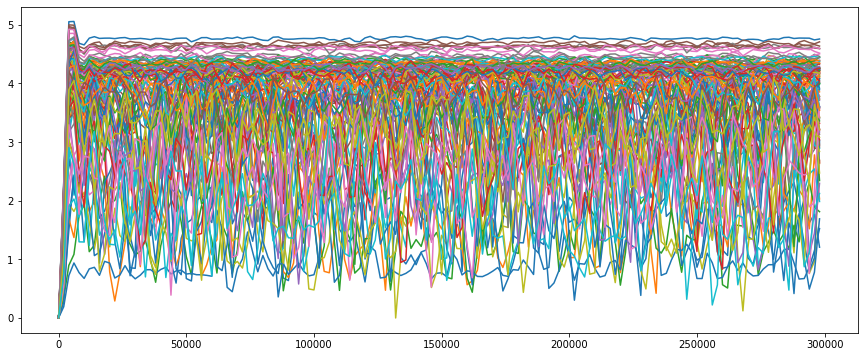

In [34]:
plt.plot(time_bold,bold);

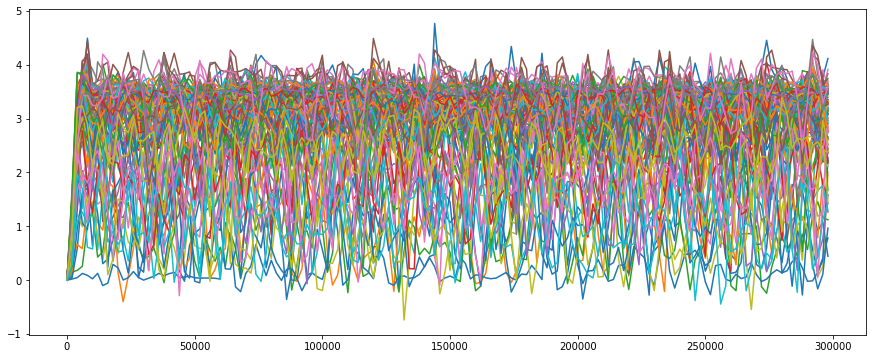

In [35]:
plt.plot(time_bold,bold-bold2);

In [36]:
FCD_SUM,FCD_MEAN,FCD_VAR,FCD_OSC = collect_FCD(G_TAU[try_idx_g],N_TAU[try_idx_n],mysubj,ALPHA1,ALPHA2)
FCD_MEAN

array([0.01782155, 0.04127127, 0.06515731, 0.0885674 , 0.1123686 ])

In [37]:
FCD_SUM_OV_INTER ,FCD_MEAN_OV_INTER, FCD_VAR_OV_INTER ,FCD_OSC_OV_INTER  = collect_FCD_OV_INTER(G_TAU[try_idx_g],N_TAU[try_idx_n],mysubj,ALPHA1,ALPHA2)
FCD_MEAN_OV_INTER

array([0.11128244, 0.09496093, 0.08507928, 0.07646965, 0.06797119])

In [38]:
rsFC,FC_CORR,FS_CORR             = collect_FCSC(G_TAU[try_idx_g],N_TAU[try_idx_n],mysubj,ALPHA1,ALPHA2)
FS_CORR

array(0.17772334)

In [39]:
mysubj,myage               = collect_demo(G_TAU[3],N_TAU[0],mysubj,ALPHA1,ALPHA2)

In [40]:
bold_list           = []

win_FCD             = 40e3

#FC_TENSOR           = np.zeros([len(parce_list),len(parce_list),G_vect.shape[0],len(edge_lim)])
FC_TENSOR           = np.zeros([len(parce_list),len(parce_list),len(G_TAU),len(N_TAU),len(P_LIST)])
FC_EMP              = np.zeros([len(parce_list),len(parce_list),len(P_LIST)])
BOLD_TENSOR         = np.zeros([int((5*60)/0.5-transient),len(parce_list),len(G_TAU),len(N_TAU),len(P_LIST)])

bold,time_bold      = collect_bold(G_TAU[try_idx_g],N_TAU[try_idx_n],P_LIST[0],ALPHA1,ALPHA2)

bold_sig            = bold[transient:,:]


# FCD, _, speed_fcd   = analysis.compute_fcd(bold_sig, win_len=int(win_FCD/500), win_sp=1)
# cof                 = analysis.compute_cofluctuation(bold_sig)
# edge_cdf            = analysis.compute_edge_fcd(cof)
# RSS, top5           = analysis.cofluctuation_rss(cof)


# FCD_TENSOR          = np.empty([FCD.shape[0],FCD.shape[1],len(G_TAU),len(N_TAU),len(P_LIST)])
# EDGE_TENSOR         = np.empty([edge_cdf.shape[0],edge_cdf.shape[1],len(G_TAU),len(N_TAU),len(P_LIST)])
# RSS_TENSOR          = np.empty([RSS.shape[0],len(G_TAU),len(N_TAU),len(P_LIST)])
# THRS_TENSOR         = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

FCD_SUBJ_MEAN_INTER_TENS       = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_VAR_INTER_TENS        = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_STACK_STD_INTER_TENS       = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])


FCD_SUBJ_SUM_OV_TENS           = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_MEAN_OV_TENS          = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_VAR_OV_TENS           = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_STACK_STD_OV_TENS          = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

FCD_SUBJ_DIFF             = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_RATIO            = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

FCD_SUBJ_DIFF_VAR         = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_RATIO_VAR        = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)]) 

FCD_SUBJ_DIFF_OV_TENS            = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_RATIO_OV_TENS           = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

FCD_SUBJ_DIFF_VAR_OV_TENS        = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_RATIO_VAR_OV_TENS       = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)]) 

FCD_SUBJ_SUM        = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_MEAN       = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_MEAN_INTER = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_VAR        = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_STACK_STD       = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
EDGE_SUBJ_SUM       = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FC_CORR             = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FS_CORR             = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FS_CORR             = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

CIX_TENSOR          = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
REG_TENSOR          = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

POW_TENSOR          = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
BANDP_TENSOR        = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

MSE_TENSOR          = np.empty([20,len(G_TAU),len(N_TAU),len(P_LIST)])
MSE_REG_TENSOR      = np.empty([20,len(parce_list),len(G_TAU),len(N_TAU),len(P_LIST)])

BURST_R_TENSOR      = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
BURST_V_TENSOR      = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

BURST_R_REG_TENSOR  = np.empty([len(parce_list),len(G_TAU),len(N_TAU),len(P_LIST)])
BURST_V_REG_TENSOR  = np.empty([len(parce_list),len(G_TAU),len(N_TAU),len(P_LIST)])

NUM_MOMENT = 1

MOM_BOLD  = np.empty([len(parce_list)*NUM_MOMENT,len(G_TAU),len(N_TAU),len(P_LIST)])

RSFC_MEAN = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

HOMO_FC   = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])


# FCD_TENSOR[:]       = np.nan
# EDGE_TENSOR[:]      = np.nan
# RSS_TENSOR[:]       = np.nan
# THRS_TENSOR[:]      = np.nan

FCD_SUBJ_MEAN_INTER_TENS[:]     = np.nan
FCD_SUBJ_VAR_INTER_TENS[:]      = np.nan
FCD_STACK_STD_INTER_TENS[:]     = np.nan

FCD_SUBJ_DIFF[:]     = np.nan

FCD_SUBJ_SUM[:]      = np.nan
FCD_SUBJ_MEAN[:]     = np.nan

FCD_SUBJ_VAR[:]      = np.nan
FCD_STACK_STD[:]     = np.nan
EDGE_SUBJ_SUM[:]     = np.nan
FC_CORR[:]           = np.nan
FS_CORR[:]           = np.nan


FCD_SUBJ_SUM_OV_TENS[:]               = np.nan
FCD_SUBJ_MEAN_OV_TENS[:]               = np.nan
FCD_SUBJ_VAR_OV_TENS[:]               = np.nan
FCD_STACK_STD_OV_TENS[:]               = np.nan

FCD_SUBJ_DIFF[:]               = np.nan
FCD_SUBJ_RATIO[:]               = np.nan

FCD_SUBJ_DIFF_VAR[:]               = np.nan
FCD_SUBJ_RATIO_VAR[:]               = np.nan

FCD_SUBJ_DIFF_OV_TENS[:]               = np.nan
FCD_SUBJ_RATIO_OV_TENS[:]               = np.nan

FCD_SUBJ_DIFF_VAR_OV_TENS[:]               = np.nan
FCD_SUBJ_RATIO_VAR_OV_TENS[:]               = np.nan 


CIX_TENSOR[:]               = np.nan
REG_TENSOR[:]               = np.nan

POW_TENSOR[:]               = np.nan
BANDP_TENSOR[:]             = np.nan

MSE_TENSOR[:]               = np.nan
MSE_REG_TENSOR[:]           = np.nan

BURST_R_TENSOR[:]           = np.nan
BURST_V_TENSOR[:]           = np.nan

BURST_R_REG_TENSOR[:]       = np.nan
BURST_V_REG_TENSOR[:]       = np.nan

MOM_BOLD[:]       = np.nan

RSFC_MEAN[:]       = np.nan

FCD_EMP             = []
EDGE_EMP            = []
BOLD_EMP            = []


FCD_MEAN_EMP  = []
FCD_VAR_EMP   = []
FCD_MEAN_EMP_inter  = []
FCD_VAR_EMP_inter   = []


FCD_MEAN_EMP_OV    = []
FCD_VAR_EMP_OV     = []


FCD_SUM_EMP       =[]
FCD_MEAN_EMP      =[]
FCD_VAR_EMP       =[]
FCD_OSC_EMP       =[]


FCD_SUM_OV_EMP    =[]
FCD_MEAN_OV_EMP   =[]
FCD_VAR_OV_EMP    =[]

FCD_INTER_SUM_EMP       =[]
FCD_INTER_MEAN_EMP      =[]
FCD_INTER_VAR_EMP       =[]
FCD_INTER_MAX_EMP       =[]
FCD_INTER_OSC_EMP       =[]

FCD_SUBJ_DIFF_EMP           =[]
FCD_SUBJ_RATIO_EMP          =[]

FCD_SUBJ_DIFF_VAR_EMP       =[]
FCD_SUBJ_RATIO_VAR_EMP      =[]


FCD_SUBJ_DIFF_OV_EMP       = []
FCD_SUBJ_RATIO_OV_EMP      = []

FCD_SUBJ_DIFF_VAR_OV_EMP   = []
FCD_SUBJ_RATIO_VAR_OV_EMP  = []

FCD_INTER_MEAN_EMP      =[]
FCD_INTER_VAR_EMP       =[]
FCD_INTER_MAX_EMP       =[]

FCD_INTER_MEAN_OV_EMP   =[]
FCD_INTER_VAR_OV_EMP    =[]
FCD_INTER_MAX_OV_EMP    =[]

SC_SC_inter             =[]

RSFC_MEAN_EMP  = []

SC_SC_inter = []


myage_list  =[]
mysubj_list =[]

mygender_list  =[]
myedu_list     =[]

speed_down          = 9
speed_up            = 32

NHALF               = int(len(parce_list)/2)

mask_intra                              = np.zeros([NHALF*2,NHALF*2])
mask_intra[0:NHALF,0:NHALF]             = 1
mask_intra[NHALF:NHALF*2,NHALF:NHALF*2] = 1

mask_inter                              = np.zeros([NHALF*2,NHALF*2])
mask_inter[0:NHALF,NHALF:NHALF*2]       = 1
mask_inter[NHALF:NHALF*2,0:NHALF]       = 1

SEG_FC_EMP  = []
WITH_FC_VIS_EMP = []
WITH_FC_SMN_EMP = []
WITH_FC_DMN_EMP = []
HOMO_FC_EMP = []

for subj_idx in range(len(P_LIST)):
# for subj_idx in [90,91]:
    
    mysubj     = P_LIST[subj_idx]
#     print(['SUBJ --> ',mysubj])
    bold_emp   = jul.load_subject_fc_100(mysubj)
    _,weights  = jul.load_subject_sc_100(mysubj)
    rsFC_emp   = np.corrcoef(bold_emp.T)
    rsFC_emp   = rsFC_emp * (rsFC_emp>0)
    rsFC_emp   = rsFC_emp - np.diag(np.diagonal(rsFC_emp))
    
    within_FC,_,_              = FC_analysis.within_conn(rsFC_emp,rsn_net)
    between_FC                 = FC_analysis.between_conn(rsFC_emp,rsn_left,rsn_right)

    strength_with              = sum(within_FC)/len(within_FC)
    strength_bet               = sum(between_FC)/len(between_FC)

    segregation_FC             = FC_analysis.segregation_score(strength_with,strength_bet)
    
    FC_FC_homo                 = np.diag(rsFC_emp,k=NHALF)
    
    STATIC_FC_TRIU             = np.diag(rsFC_emp,k=1)
    
    SEG_FC_EMP  += [segregation_FC]
    WITH_FC_VIS_EMP += [within_FC[0]]
    WITH_FC_SMN_EMP += [within_FC[1]]
    WITH_FC_DMN_EMP += [within_FC[2]]
    HOMO_FC_EMP += [np.mean(FC_FC_homo)]
    
    RSFC_MEAN_EMP += [np.mean(STATIC_FC_TRIU)]
    
#     FCD_MEAN_EMP_entry,FCD_VAR_EMP_entry,FCD_MEAN_EMP_inter_entry,FCD_VAR_EMP_inter_entry,FCD_MEAN_EMP_OV_entry,FCD_VAR_EMP_OV_entry = collect_empirical(mysubj)
    
#     FCD_MEAN_EMP += [FCD_MEAN_EMP_entry]
#     FCD_VAR_EMP  += [FCD_VAR_EMP_entry]
    
#     FCD_MEAN_EMP_inter += [FCD_MEAN_EMP_inter_entry]
#     FCD_VAR_EMP_inter  += [FCD_VAR_EMP_inter_entry]
    
#     FCD_MEAN_EMP_OV    += [FCD_MEAN_EMP_OV_entry]
#     FCD_VAR_EMP_OV     += [FCD_VAR_EMP_OV_entry]

    transient    = int(5e3/2250)
    win_FCD      = 40e3
    FCD, fc_stack, speed_fcd      = analysis.compute_fcd(bold_emp[transient:,:], win_len=int(win_FCD/2250), win_sp=1)
    fcd_inter, fc_stack_inter, _  = analysis.compute_fcd_filt(bold_emp[transient:,:],mask_inter,win_len=int(win_FCD/2250),win_sp=1)
    
    FCD_TRIU            = np.triu(FCD, k=1)
    FCD_TRIU_OV         = np.triu(FCD, k=int(win_FCD/2250))


    FCD_SUM_EMP       +=[sum(sum(FCD_TRIU))]
    FCD_MEAN_EMP      +=[np.mean(FCD_TRIU)]
    FCD_VAR_EMP       +=[np.var(FCD_TRIU)]
    FCD_OSC_EMP       +=[np.std(fc_stack)]
    
    FCD_INTER_OSC_EMP +=[np.std(fc_stack_inter)]


    FCD_SUM_OV_EMP    +=[sum(sum(FCD_TRIU_OV))]
    FCD_MEAN_OV_EMP   +=[np.mean(FCD_TRIU_OV)]
    FCD_VAR_OV_EMP    +=[np.var(FCD_TRIU_OV)]
    
    FCD_INTER_TRIU      = np.triu(fcd_inter, k=1)
    FCD_INTER_TRIU_OV   = np.triu(fcd_inter, k=int(win_FCD/2250))

    FCD_INTER_MEAN_EMP      +=[np.mean(FCD_INTER_TRIU)]
    FCD_INTER_VAR_EMP       +=[np.var(FCD_INTER_TRIU)]
    FCD_INTER_MAX_EMP       +=[np.max(FCD_INTER_TRIU)]
#     FCD_INTER_OSC_EMP       +=[np.std(fc_stack_inter)

    FCD_INTER_MEAN_OV_EMP      +=[np.mean(FCD_INTER_TRIU_OV)]
    FCD_INTER_VAR_OV_EMP       +=[np.var(FCD_INTER_TRIU_OV)]
    FCD_INTER_MAX_OV_EMP       +=[np.max(FCD_INTER_TRIU_OV)]
    
    FCD_SUBJ_DIFF_EMP          +=[np.mean(FCD_INTER_TRIU)-np.mean(FCD_TRIU)]
    FCD_SUBJ_RATIO_EMP         +=[np.mean(FCD_INTER_TRIU)/np.mean(FCD_TRIU)]
    
    FCD_SUBJ_DIFF_VAR_EMP      +=[np.var(FCD_INTER_TRIU)-np.var(FCD_TRIU)]
    FCD_SUBJ_RATIO_VAR_EMP     +=[np.var(FCD_INTER_TRIU)/np.var(FCD_TRIU)]
    
    FCD_SUBJ_DIFF_OV_EMP       +=[np.mean(FCD_INTER_TRIU_OV)-np.mean(FCD_TRIU_OV)]
    FCD_SUBJ_RATIO_OV_EMP      +=[np.mean(FCD_INTER_TRIU_OV)/np.mean(FCD_TRIU_OV)]
    
    FCD_SUBJ_DIFF_VAR_OV_EMP   +=[np.var(FCD_INTER_TRIU_OV)-np.var(FCD_TRIU_OV)]
    FCD_SUBJ_RATIO_VAR_OV_EMP  +=[np.var(FCD_INTER_TRIU_OV)/np.var(FCD_TRIU_OV)]
    
    mask_inter                              = np.zeros(weights.shape)
    mask_inter[0:NHALF,NHALF:NHALF*2]       = 1
    mask_inter[NHALF:NHALF*2,0:NHALF]       = 1

    weights_inter                           = (weights*mask_inter).ravel()
    weights_inter_vec                       = weights_inter[mask_inter.ravel()>0]
    
    SC_SC_inter                +=[np.mean(weights_inter_vec)]

#     mysubj,myage               = collect_demo(G_TAU[0],N_TAU[0],mysubj,ALPHA1,ALPHA2)
    
    mysubj,myage               = collect_demo(G_TAU[0],N_TAU[0],mysubj,ALPHA1,ALPHA2)
    
    SUBJ_TARG  = [subj_loc for subj_loc in range(len(subj_ID)) if str(mysubj) in subj_ID[subj_loc] ][0]
    
    myage_list    +=[float(myage)]
    mysubj_list   +=[mysubj]
    myedu_list    +=[education[SUBJ_TARG]]
    mygender_list +=[gender[SUBJ_TARG]]
                        
    for n_idx in range(len(N_TAU)):
        for g_idx in range(len(G_TAU)):
#     for n_idx in [4]:
#         for g_idx in [3]:

            try:
        
        #                 if g_idx%20 == 0:
        #                     print(['G --> ',str(G_TAU[g_idx]),'noise --> ',str(N_TAU[n_idx])])

                bold,time_bold             = collect_bold(G_TAU[g_idx],N_TAU[n_idx],mysubj,ALPHA1,ALPHA2)


        #                 v,time_v                      = collect_tavg_v(G_TAU[g_idx],N_TAU[n_idx],loc_idx,ALPHA1,ALPHA2)
        #                 r,time_r                      = collect_tavg(G_TAU[g_idx],N_TAU[n_idx],loc_idx,ALPHA1,ALPHA2)

        #                 idr,_,_,BURST_R               = Burstiness.Burstiness(r,10,0.01)
        #                 idv,_,_,BURST_V               = Burstiness.Burstiness(v,10,-1.6)

        #                 plot_bold(bold,time_bold,subjs[loc_idx],loc_idx,G_TAU[g_idx],N_TAU[n_idx],25,ALPHA1,ALPHA2)

                transient = int(5e3/2000)
                bold_sig  = bold[transient:,:]

                rsFC      = np.corrcoef(bold_sig.T)
                rsFC      = rsFC * (rsFC>0)
                rsFC      = rsFC - np.diag(np.diagonal(rsFC))

        #                 bold_list += [bold_sig]

        #                 fcd_inter, fc_stack_inter, _ = analysis.compute_fcd_filt(bold_sig[transient:,:],mask_inter, win_len=int(win_FCD/2000), win_sp=1)
        #                 fcd_full, fc_stack_full, _ = analysis.compute_fcd(bold_sig[transient:,:], win_len=int(win_FCD/2000), win_sp=1)

        #                 FCD_TRIU_INTER                              = np.triu(fcd_inter, k=int(win_FCD/2000))
        #                 FCD_SUBJ_MEAN_INTER[g_idx,n_idx,subj_idx]   = np.mean(FCD_TRIU_INTER)
        #                 FCD_SUBJ_VAR_INTER[g_idx,n_idx,subj_idx]    = np.var(FCD_TRIU_INTER)
        #                 FCD_STACK_STD_INTER[g_idx,n_idx,subj_idx]   = np.std(fc_stack_inter)

                FCD_SUM,FCD_MEAN,FCD_VAR,FCD_OSC                                         = collect_FCD(G_TAU[g_idx],N_TAU[n_idx],mysubj,ALPHA1,ALPHA2)

                FCD_SUBJ_SUM[g_idx,n_idx,subj_idx]   = FCD_SUM[3]
                FCD_SUBJ_MEAN[g_idx,n_idx,subj_idx]  = FCD_MEAN[3]
                FCD_SUBJ_VAR[g_idx,n_idx,subj_idx]   = FCD_VAR[3]
                FCD_STACK_STD[g_idx,n_idx,subj_idx]  = FCD_OSC[3]

                FCD_SUM,FCD_MEAN,FCD_VAR,FCD_OSC                             = collect_FCD(G_TAU[g_idx],N_TAU[n_idx],mysubj,ALPHA1,ALPHA2)
                FCD_SUM_INTER ,FCD_MEAN_INTER, FCD_VAR_INTER ,FCD_OSC_INTER  = collect_FCD_INTER(G_TAU[g_idx],N_TAU[n_idx],mysubj,ALPHA1,ALPHA2)

                FCD_SUM_OV,FCD_MEAN_OV,FCD_VAR_OV,FCD_OSC_OV                             = collect_FCD_OV(G_TAU[g_idx],N_TAU[n_idx],mysubj,ALPHA1,ALPHA2)
                FCD_SUM_OV_INTER ,FCD_MEAN_OV_INTER, FCD_VAR_OV_INTER ,FCD_OSC_OV_INTER  = collect_FCD_OV_INTER(G_TAU[g_idx],N_TAU[n_idx],mysubj,ALPHA1,ALPHA2)

                FCD_SUBJ_SUM_OV_TENS[g_idx,n_idx,subj_idx]   = FCD_SUM_OV[3]
                FCD_SUBJ_MEAN_OV_TENS[g_idx,n_idx,subj_idx]  = FCD_MEAN_OV[3]
                FCD_SUBJ_VAR_OV_TENS[g_idx,n_idx,subj_idx]   = FCD_VAR_OV[3]
                FCD_STACK_STD_OV_TENS[g_idx,n_idx,subj_idx]  = FCD_OSC_OV[3]

                FCD_STACK_STD_INTER_TENS[g_idx,n_idx,subj_idx]  = FCD_OSC_OV_INTER[3]

                FCD_SUBJ_MEAN_INTER_TENS[g_idx,n_idx,subj_idx]  = FCD_MEAN_OV_INTER[3]

                FCD_SUBJ_DIFF[g_idx,n_idx,subj_idx]           = FCD_MEAN_INTER[3] - FCD_MEAN[3]
                FCD_SUBJ_RATIO[g_idx,n_idx,subj_idx]          = FCD_MEAN_INTER[3]/FCD_MEAN[3]

                FCD_SUBJ_DIFF_VAR[g_idx,n_idx,subj_idx]       = FCD_VAR_INTER[3] - FCD_VAR[3]
                FCD_SUBJ_RATIO_VAR[g_idx,n_idx,subj_idx]      = FCD_VAR_INTER[3]/FCD_VAR[3]

                FCD_SUBJ_DIFF_OV_TENS[g_idx,n_idx,subj_idx]        = FCD_MEAN_OV_INTER[3] - FCD_MEAN_OV[3]
                FCD_SUBJ_RATIO_OV_TENS[g_idx,n_idx,subj_idx]       = FCD_MEAN_OV_INTER[3]/FCD_MEAN_OV[3]

                FCD_SUBJ_DIFF_VAR_OV_TENS[g_idx,n_idx,subj_idx]    = FCD_VAR_OV_INTER[3] - FCD_VAR_OV[3]
                FCD_SUBJ_RATIO_VAR_OV_TENS[g_idx,n_idx,subj_idx]   = FCD_VAR_OV_INTER[3]/FCD_VAR_OV[3]

                rsFC_entry ,FC_CORR_entry ,FS_CORR_entry      = collect_FCSC(G_TAU[g_idx],N_TAU[n_idx],mysubj,ALPHA1,ALPHA2)

        #                 FC_CORR_entry           = np.corrcoef([rsFC.ravel(),rsFC_emp.ravel()])[0,1]
        #                 FS_CORR_entry           = np.corrcoef([rsFC.ravel(),np.log10(weights+1).ravel()])[0,1]
        #                 rsFC_entry              = rsFC

                FC_CORR[g_idx,n_idx,subj_idx]           = FC_CORR_entry 
                FS_CORR[g_idx,n_idx,subj_idx]           = FS_CORR_entry 
                FC_TENSOR[:,:,g_idx,n_idx,subj_idx]     = rsFC_entry 


                STATIC_FC_TRIU                          = np.triu(FC_CORR, k=1)
                RSFC_MEAN[g_idx,n_idx,subj_idx]         = np.mean(STATIC_FC_TRIU)

                FC_FC_HOMO_SIM                          = np.diag(rsFC,k=NHALF)

                HOMO_FC[g_idx,n_idx,subj_idx]           = np.mean(FC_FC_HOMO_SIM)

                bold_zs       = zscore(bold)

    #                 momenta_bold  = np.concatenate((np.mean(bold_zs, axis=0), 
    #                                     np.median(bold_zs, axis=0),
    #                                     np.std(bold_zs, axis=0),
    #                                     skew(bold_zs, axis=0), 
    #                                     kurtosis(bold_zs, axis=0),
    #                                     ))

#                 momenta_bold  = np.concatenate((np.std(bold_zs, axis=0)))
        
                momenta_bold  = np.std(bold_zs, axis=0)

                MOM_BOLD[:,g_idx,n_idx,subj_idx] = momenta_bold




                #                 FCD_TENSOR[:,:,g_idx,n_idx,subj_idx]    = FCD

                #                 EDGE_TENSOR[:,:,g_idx,n_idx,subj_idx]   = edge_cdf

                #                 RSS_TENSOR[:,g_idx,n_idx,subj_idx]      = RSS
                #                 THRS_TENSOR[g_idx,n_idx,subj_idx]       = top5


                #                 plot_mse(mse,frequency,psd_full,subjs[loc_idx],loc_idx,G_TAU[g_idx],N_TAU[n_idx],25,ALPHA1,ALPHA2)



            except:
                print('ERROR')
                pass
            
            
print('END UPLOAD')



END UPLOAD


In [41]:
MOM_BOLD_G = MOM_BOLD[:,:,0].T 
MOM_BOLD_G.shape
RSFC_MEAN.shape

(1000, 1, 1)

In [42]:
# sum_stats_vec = np.concatenate((FCD_SUBJ_MEAN_OV_TENS[:,:,0], 
#                                 FCD_SUBJ_VAR_OV_TENS[:,:,0],
#                                 FCD_STACK_STD_INTER_TENS[:,:,0], 
#                                 FCD_SUBJ_DIFF_VAR_OV_TENS[:,:,0])
#                                ,axis=1)
sum_stats_vec = np.concatenate((HOMO_FC[:,:,0],
                                FCD_SUBJ_MEAN_OV_TENS[:,:,0], 
                                FCD_SUBJ_VAR_OV_TENS[:,:,0],
                                FCD_STACK_STD_INTER_TENS[:,:,0], 
                                FCD_SUBJ_DIFF_VAR_OV_TENS[:,:,0])
                               ,axis=1)
sum_stats_vec = np.array(sum_stats_vec,dtype='float32')
G_THETA       = np.array(G_TAU)[np.sum(np.isnan(sum_stats_vec),axis=1)==0]
sum_stats_vec = sum_stats_vec[np.sum(np.isnan(sum_stats_vec),axis=1)==0,:]
sum_stats_vec = sum_stats_vec[np.sum(sum_stats_vec,axis=1)<np.inf,:]
sum_stats_vec.shape

(989, 5)

Define the simulation function via TVB backend and time rescaling. The BOLD is derived moving average of the R signal

### load SC

Upload SC matrix from an aged empirical connectome

In [43]:
SC_healthy = weights/magic_number

In [44]:
SC_aged    = SC_healthy

In [45]:
SC_aged.shape, SC_aged.min(), SC_aged.max()

((100, 100), 0.0, 0.4381386864667595)

### simulation set up

In [46]:
dt         = 0.005
eta        = -4.6
J          = 14.5
Delta      = 0.7
tau        = 1.7
nsigma     = 0.035
seed       = 42
sim_len    = 30e3

In [47]:
G          = 2.45

Check if the simulation with backend works and the CPU time for each run. According to Meysam's formalism, each signal matrix MUST BE (NODES X TIME). 

### data features

Compute the summary statistics via numpy and scipy. The function here extracts 10 momenta for each bold channel, FC mean, FCD mean, variance difference and standard deviation of FC stream. Check that you can compute FCD features via proper FCD packages

In [48]:
from scipy import signal
from scipy.signal import hilbert

from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode



from scipy.optimize import fsolve
from scipy.optimize import root

from numpy import linalg as LA
from sklearn.decomposition import PCA

### 1. Simulator wrapper

Define the wrapper such that you can iterate the simulator with SBI

### 2. Prior over model parameters

Define the uniform prior and store it in a utils function for the SBI inference

In [49]:
prior_min_alpha=0.
prior_min_G=1.5*np.ones(1)

prior_max_alpha=1.
prior_max_G=3.2*np.ones(1)

In [50]:
# prior_min=np.hstack([prior_min_alpha, prior_min_G])
# prior_max=np.hstack([prior_max_alpha, prior_max_G])

prior_min=np.hstack([prior_min_G])
prior_max=np.hstack([prior_max_G])

In [51]:
prior_min.shape, prior_max.shape

((1,), (1,))

In [52]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))
prior

BoxUniform(Uniform(low: tensor([1.5000]), high: tensor([3.2000])), 1)

### 3. Inference

Inference procedure. Although the inference function is defined in the SBI toolbox, the function below shows that you can potentially split the simulation step from the inference 
in case that it is needed. For example, the simulation time for the wrappper is too long and you might want to parallelize on HPC facilities. The inference function produces a posterorior object, which contains a neural network for posterior density estimation

In [53]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast
# from warnings import warn

# import torch
# from torch import Tensor
# from torch.utils import data
# from torch.utils.tensorboard import SummaryWriter

import sbi.inference
from sbi.inference.posteriors.base_posterior import NeuralPosterior

In [54]:
def myinfer(prior, theta, x):
    
    inference = SNPE(prior)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior()

    return posterior

In [55]:
theta = np.array(G_THETA,dtype='float32')
theta = theta.reshape(theta.shape[0],1)

In [56]:
x     = sum_stats_vec
x     = torch.as_tensor(x)
theta = np.array(G_THETA,dtype='float32')
theta = theta.reshape(theta.shape[0],1)
theta = torch.as_tensor(theta.T)

In [57]:
start_time = time.time()

# posterior = myinfer(MPR_simulator_wrapper, prior, method='SNPE',  num_simulations=20, num_workers=1)
x     = sum_stats_vec
x     = torch.as_tensor(x)
theta = np.array(G_THETA,dtype='float32')
theta = theta.reshape(theta.shape[0],1)
theta = torch.as_tensor(theta)
posterior = myinfer(prior, theta, x)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

/Users/mariolavanga/Documents/GitHub/ageing_virtual_brain/env/lib/python3.7/site-packages/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 86 epochs.
------------------------------------------------------------
--- 19.64456343650818 seconds ---


### SUMMARY STATISTICS TO GET THE POSTERIOR

In order to compute $p(\theta|x)$, you need to pass a vector of summary statistics input $x$ to the ANN-posterior estimator. It can either be defined on target simulation data for validation purposes or the empirical data for "therapy" reason

In [58]:
alpha_true= 0.0
beta_true = 0.0
G_true    = 2.45

In [59]:
labels_params = [r'$G$']

In [60]:
params_true = np.hstack([alpha_true, G_true])

In [61]:
SC_aged_true=SC_healthy

The block below chooses between a validation with a simulation or empirical data

In [62]:
bold_emp_zs = zscore(bold_emp)
# X_MOMENTA   = np.concatenate((np.mean(bold_emp_zs, axis=0), np.median(bold_emp_zs, axis=0), np.std(bold_emp_zs, axis=0), skew(bold_emp_zs, axis=0), kurtosis(bold_emp_zs, axis=0)))
# X_MOMENTA   = np.concatenate((np.std(bold_emp_zs, axis=0)))
X_MOMENTA   = np.std(bold_emp_zs, axis=0)

In [63]:
# obs_summary_statistics = np.concatenate((RSFC_MEAN_EMP,
#                                          FCD_MEAN_OV_EMP,
#                                          FCD_VAR_OV_EMP,
#                                          FCD_OSC_EMP,
#                                          FCD_INTER_OSC_EMP,
#                                          FCD_SUBJ_DIFF_EMP,
#                                          FCD_SUBJ_DIFF_VAR_EMP))
obs_summary_statistics = np.concatenate((HOMO_FC_EMP,
                                         FCD_MEAN_OV_EMP,
                                         FCD_VAR_OV_EMP,
                                         FCD_INTER_OSC_EMP,
                                         FCD_SUBJ_DIFF_VAR_EMP))

# obs_summary_statistics = np.concatenate((FCD_MEAN_OV_EMP,
#                                          FCD_VAR_OV_EMP,
#                                          FCD_INTER_OSC_EMP,
#                                          FCD_SUBJ_DIFF_VAR_EMP))

obs_summary_statistics.shape

(5,)

## POSTERIOR DISTRIBUTION

The last step derive or upload the posterior

In [64]:
alpha_true= 0.0
beta_true = 0.0
G_true    = 2.45

In [65]:
params_true = np.hstack([G_true])

In [66]:
num_samples=1000

In [67]:
posterior_samples = posterior.sample((num_samples,), obs_summary_statistics, sample_with_mcmc=True,).numpy()

Generating samples: 100%|██████████| 1000/1000 [01:31<00:00, 10.93it/s]


In [68]:
G_posterior=posterior_samples[:,0]

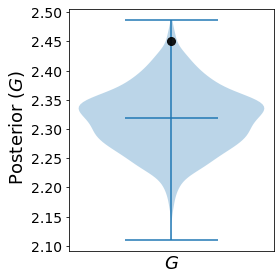

In [69]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[0] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=18); 
plt.xticks([])
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

## CHECK DISTRIBUTION

In [70]:
separator  = ''
P_LIST     = ['sub-1209']
AGE_LIST   = [76.3]
mysubj_idx = 0
mysubj     = P_LIST[mysubj_idx]
magic_number = 124538.470647693 #SC COHORT MAX FOR JULICH DATASET
BOLD_TR      = 2200
print(len(P_LIST))

1


In [71]:
dt         = 0.005
eta        = -4.6
J          = 14.5
Delta      = 0.7
tau        = 1.7
nsigma     = 0.035
seed       = 42
sim_len    = 30e3

In [72]:
def run_sim(G,nsigma,mysubj,sim_len,BOLD_TR):
    
    t0 = time.time()
    
    jul                                       = data.Julich()
    subjs                                     = jul.list_subjects()
    subj_age,gender,education,subj_ID,_,_,_,_ = jul.metadata()
    magic_number = 124538.470647693

    SUBJ_TARG     = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]
    myage         = subj_age[SUBJ_TARG]

    _, weights    = jul.load_subject_sc_100(mysubj)
    NHALF         = int(weights.shape[0]/2)

#     print(mysubj,flush=True)
#     print(subj_ID[SUBJ_TARG],flush=True)
#     print(myage,flush=True)
#     print(str(tau),flush=True)
#     print(str(G),flush=True)

    weights_orig                            = weights/magic_number
    weights_symm                            = weights_orig 

    
    conn               = connectivity.Connectivity(
        weights=weights_symm,
        region_labels=np.array(np.zeros(np.shape(weights_symm)[0]),dtype='<U128'),
        tract_lengths=np.zeros(np.shape(weights_symm)),
        areas =np.zeros(np.shape(weights_symm)[0]),
        speed=np.array(np.Inf,dtype=float),
        centres = np.zeros(np.shape(weights_symm)[0])) # default 76 regions 
    # conn_speed         = np.Inf  
    # conn.weights       = weights_symm
    # conn.areas         = np.zeros(np.shape(weights_symm))
    # conn.tract_lengths = np.zeros(np.shape(weights_symm))
#     print('weight:',weights_symm) 
#     print('shape :',np.shape(conn.weights))
#     print('conn :', conn.weights)

    mpr=models.MontbrioPazoRoxin(
            eta   = np.r_[-4.6],
            J     = np.r_[14.5],
            Delta = np.r_[0.7],
            tau   = np.r_[1],
        )
#     mpr.state_variable_range['r'] = np.array([0.,.25])

    sim = simulator.Simulator(model=mpr,
    connectivity=conn,
        coupling=coupling.Scaling(
          a=np.r_[G]
        ),
    conduction_speed=np.Inf,
        integrator=integrators.HeunStochastic(
          dt=dt,
          noise=noise.Additive(
              nsig=np.r_[nsigma, nsigma*2],
              noise_seed=seed
          )
    ),
    monitors=[
          monitors.TemporalAverage(period=0.1),
        ]
    )

    sim.configure()

    (TemporalAverage_time, TemporalAverage_data), = simulation.run_nbMPR_backend(sim, simulation_length=sim_len)
    TemporalAverage_time *= 10 # rescale time
    
#     Bold_time, Bold_data = simulation.tavg_to_bold(TemporalAverage_time, TemporalAverage_data, tavg_period=1., connectivity=sim.connectivity, svar=0, decimate=2000)
    
    R_TAVG = TemporalAverage_data[:,0,:,0]
#     V = TemporalAverage_data[:,1,:,0]
    
    R = scipy.signal.decimate(R_TAVG, BOLD_TR, n=None, ftype='fir',axis=0)

#     CPU_TIME = time.time() - t0
#     print(['CPU time-->',CPU_TIME])


    return R.T

In [74]:
BOLD_TR     = 2200
nsigma_post = 0.035
G_post      = np.mean(G_posterior)
start_time  = time.time()
BOLD_r      = run_sim(G,nsigma,mysubj,sim_len,BOLD_TR)
# bold_data = run_sim(G,nsigma,mysubj,alpha,sim_len)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 204.04163193702698


0.6481502566951601
0.04505879285163605


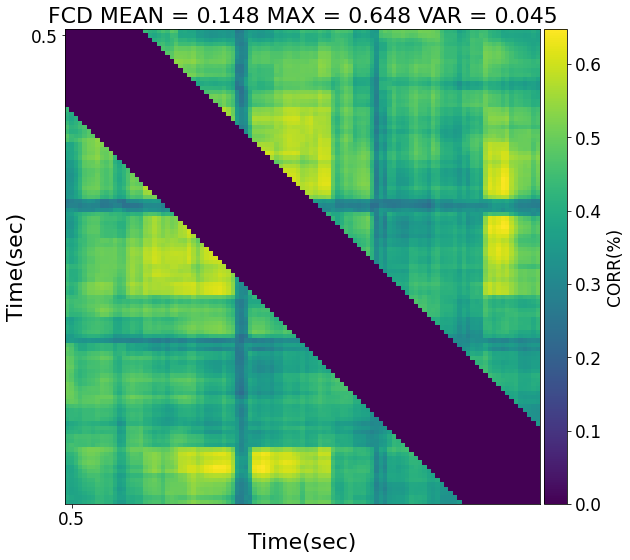

In [78]:
path_root  = os.path.dirname(os.getcwd())

# ALPHA1 = 0.8
# ALPHA2 = 0.2


# mysubj = P_LIST[PAT_IDX]
# myflag = FLAG_LIST[PAT_IDX]
# G_CHOS = int(TUNE_FCD_MAX[PAT_IDX,0])
# N_CHOS = int(TUNE_FCD_MAX[PAT_IDX,1])

G_CHOS = 24
N_CHOS = 6
font_size = 12

win_FCD = 40e3

from mpl_toolkits.axes_grid1 import make_axes_locatable
FCD, fc_stack, speed_fcd = analysis.compute_fcd(BOLD_r.T[10:,:], win_len=int(win_FCD/BOLD_TR), win_sp=1)
FCD_plot = np.triu(FCD, k=int(win_FCD/BOLD_TR)) + np.tril(FCD, k=-int(win_FCD/BOLD_TR))
# FCD_plot = FCD
print(np.max(np.triu(FCD_plot, k=int(win_FCD/BOLD_TR))))
f,ax = plt.subplots(figsize=(9,9))
image = ax.imshow(FCD_plot)
ax.set_ylabel("Time(sec)",fontsize=font_size+10)
ax.set_xlabel("Time(sec)",fontsize=font_size+10)
ax.tick_params(axis='x', labelsize=font_size+5)
ax.tick_params(axis='y', labelsize=font_size+5)


loc   = range(1,FCD.shape[0],120)
label = np.array(loc)*0.5
label = label.round(2)

plt.xticks(loc, label);
plt.yticks(loc, label);
mean_FCD = np.mean(np.triu(FCD_plot, k=int(win_FCD/2000)))
max_FCD = np.max(np.triu(FCD_plot, k=int(win_FCD/2000)))
var_FCD = np.var(np.triu(FCD_plot, k=int(win_FCD/2000)))
min_FCD = np.min(np.triu(FCD_plot, k=int(win_FCD/2000)))
separator = ''
str_title = separator.join(["FCD MEAN = ",f"{mean_FCD:.3f}"," MAX = ",f"{max_FCD:.3f}"," VAR = ",f"{var_FCD:.3f}"])
plt.title(str_title,fontsize=font_size+10)
                         
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("CORR(%)",fontsize=font_size+5)
cbar.ax.tick_params(labelsize=font_size+5)                 
        
# print(G_TAU[G_CHOS]) 
# print(N_TAU[N_CHOS])
# separator = ''
# str_figurefile = separator.join(['documentation/figures/FCD_TUNE_alpha1',f"{ALPHA1}",'_alpha2',f"{ALPHA2}",'.jpeg'])
# path_fig = os.path.abspath(os.path.join(path_root,str_figurefile))
# plt.savefig(path_fig,dpi=100)
print(var_FCD)

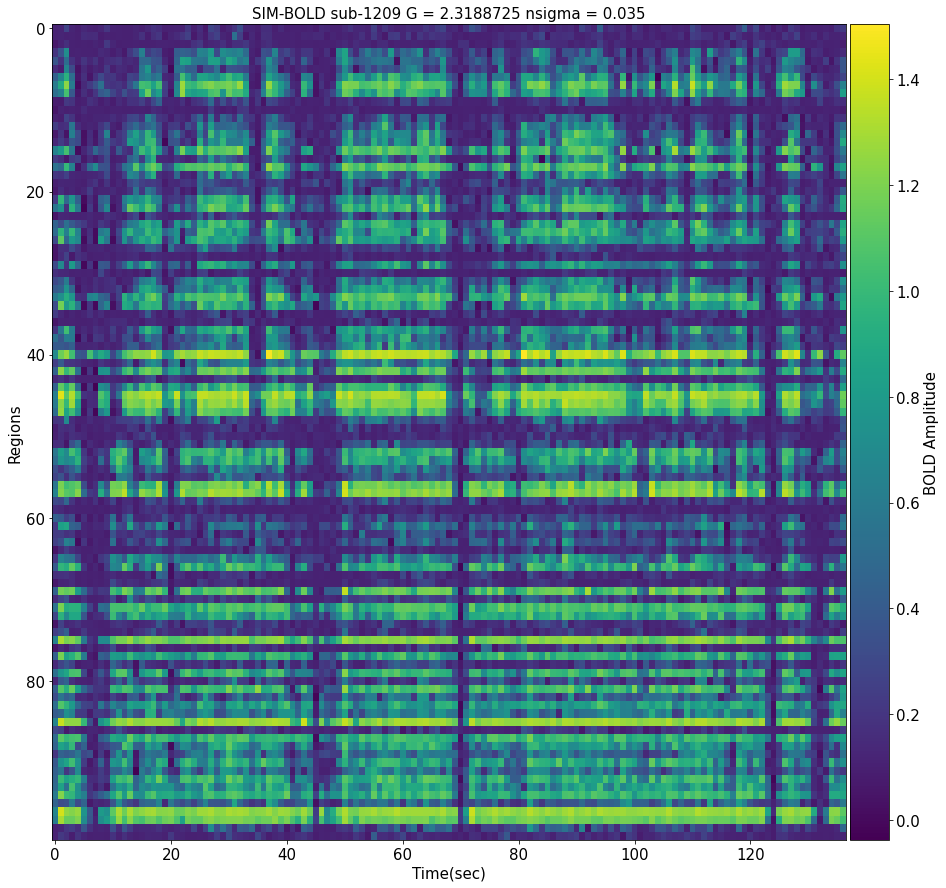

In [80]:
f,ax = plt.subplots(figsize=(15,15))
# image = ax.imshow(bold[:,vis_rsn].T)
font_size = 15
image = ax.imshow(BOLD_r,aspect='auto')

mytit = separator.join(['SIM-BOLD ',mysubj,' G = ', str(G_post), 
                        ' nsigma = ', str(nsigma_post)])

ax.set_title(mytit,fontsize = font_size)
ax.tick_params(axis="x", labelsize=font_size)  
ax.tick_params(axis="y", labelsize=font_size)
ax.set_xlabel('Time(sec)', fontsize=font_size)
ax.set_ylabel('Regions', fontsize=font_size)

# loc   = range(1,FCD_TENSOR[:,:,19,5,0].shape[0],120)
# label = np.array(loc)*0.5
# label = label.round(2)

# plt.xticks(loc, label);

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("BOLD Amplitude",fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)

# separator = ''
# str_figurefile = separator.join(['documentation/figures/BOLD_alpha1',f"{ALPHA1}",'_alpha2',f"{ALPHA2}",'.jpeg'])
# path_fig = os.path.abspath(os.path.join(path_root,str_figurefile))
# plt.savefig(path_fig,dpi=100)